<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf backup/

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 6.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [5]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2022,1,31)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075


Nuevos indicadores
- MACD
- Retrocesos de Fibonacci
- ADX


https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [6]:
price = 'Close'

#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
values_ma = [5,10,15,30]

for i in values_ma:
    df["ma_close_" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,10,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df[price].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,10,14,21]
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std()  * 2)

In [7]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
Date,,,,,,,,,,,,,,,,,,,,,,,
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629,36775.098437,38016.343750,39626.435677,42071.771224,37102.710019,38060.480683,39085.675145,41677.269577,27.755463,23.869331,25.859280,32.104422,37432.889814,36117.307061,43157.982976,32874.704524,46326.124569,34328.705119
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523,37076.603906,37557.213672,39305.953125,41783.091927,37329.917357,38010.271837,38923.007256,41426.112316,65.131604,27.719120,26.753990,38.111293,37941.715195,36211.492617,41689.710650,33424.716694,46193.378676,34066.490074
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075,37373.374219,37196.598828,38975.185156,41481.760417,37599.338134,38033.527810,38824.903810,41213.987630,96.923545,32.015610,28.481444,38.796999,38494.391950,36252.356487,40172.771521,34220.426135,46006.110359,33876.416203
2022-01-30,38151.917969,38266.339844,37437.710938,37917.601562,14643548444,37566.093750,36920.317187,38624.532031,41202.132292,37705.425943,38012.450310,38711.491029,41001.317561,85.892362,34.955981,28.104465,37.589432,38657.555434,36474.632066,38752.030710,35088.603665,45807.435730,33684.724817
2022-01-31,37920.281250,38647.261719,36733.574219,38483.125000,20734730465,37892.294531,37122.898047,38315.815104,40895.342708,37964.658962,38098.027527,38682.945275,40838.853525,86.964527,68.333563,33.716543,39.924923,38887.504670,36897.084393,39163.241259,35082.554835,45449.828792,33617.058708


In [8]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1432, 23)

In [9]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
past_t = 32
forecast_t = 1
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1400, 32, 23)
Shape y --> (1400, 1)
Example of day -->


,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
0,46490.605469,47879.964844,46060.312500,47178.125000,2.668649e+10,48532.325000,49226.334375,48437.798958,49361.767969,48007.816131,48509.483970,48789.547471,50197.948212,19.477868,51.428069,48.104370,48.932510,52620.329156,44444.320844,52624.673818,45827.994932,51840.484854,44986.981552
1,47169.371094,48472.527344,45819.953125,46306.445312,3.697417e+10,47631.710938,48963.317578,48347.200260,48997.655208,47440.692525,48108.931487,48479.159701,49946.883509,16.509765,35.773149,50.425312,48.013535,51156.649628,44106.772247,52835.419227,45091.215929,51780.828126,44741.032030
2,46311.746094,47827.312500,46288.484375,47686.812500,2.458267e+10,47040.989844,48869.147656,48446.178125,48704.621745,47522.732517,48032.182580,48380.116301,49801.072476,32.256956,45.435709,53.224352,46.332024,48318.156199,45763.823488,52822.392493,44915.902819,51558.995348,44721.712464
3,47680.925781,47881.406250,46856.937500,47345.218750,2.795157e+10,46992.262500,48525.215625,48479.274219,48496.187500,47463.561261,47907.280066,48250.754107,49642.630300,27.480758,29.772292,52.418309,43.867790,48180.404164,45804.120836,52333.631354,44716.799896,51547.425210,44794.056431
4,47343.542969,47510.726562,45835.964844,46458.117188,3.307163e+10,46994.943750,48088.807813,48462.680990,48404.767969,47128.413237,47643.795906,48026.674492,49437.177842,25.134550,26.665063,48.482429,49.300691,48176.951859,45812.935641,51723.598395,44454.017230,51555.380255,44770.649823
5,46458.851562,47406.546875,45752.464844,45897.574219,4.249468e+10,46738.833594,47635.579297,48397.167448,48289.058854,46718.133564,47326.301054,47760.536958,49208.816317,35.712740,26.193881,37.758921,48.248259,48235.444975,45242.222212,51099.241595,44171.916998,51531.664519,44494.450715
6,45899.359375,46929.046875,42798.222656,43569.003906,3.685108e+10,46191.345313,46911.528125,48039.326823,48055.271484,45668.423678,46643.156118,47236.595326,48844.957452,29.757863,18.431876,32.473343,36.976609,49447.414900,42935.275725,50452.639988,43370.416262,51850.058830,43766.414217
7,43565.511719,43748.718750,42645.539062,43160.929688,3.020805e+10,45286.168750,46163.579297,47674.821354,47803.966276,44832.592348,46010.024040,46727.137122,48478.245984,20.365617,18.055626,19.952186,38.527201,48953.901410,41618.436090,49345.605866,42981.552728,52155.369530,43156.982032
8,43153.570312,43153.570312,41077.445312,41557.902344,8.419661e+10,44128.705469,45560.483984,47059.712240,47505.736458,43741.029013,45200.547368,46080.982774,48031.772200,18.382157,20.605138,17.496373,38.254881,48180.117583,40077.293354,49687.657777,41433.310192,52649.016104,42134.247958
9,41561.464844,42228.941406,40672.277344,41733.941406,2.806636e+10,43183.870313,45089.407031,46453.828646,47307.797135,43071.999811,44570.255375,45537.602603,47625.460536,2.792077,24.647139,19.020314,36.749371,46685.171316,39682.569309,49801.894167,40376.919896,52975.637818,41310.318823


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

#scaler = MinMaxScaler(feature_rangetuple=(-1,1)) Try this
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1120, 32, 23)
Shape y_train --> (1120, 1)
Shape X_test  --> (280, 32, 23)
Shape y_test  --> (280, 1)
Example of day -->


,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
0,-0.823798,-0.825508,-0.820850,-0.822878,-0.822373,-0.824119,-0.825594,-0.825215,-0.822816,-0.824766,-0.825955,-0.826713,-0.829255,1.441195,0.804999,1.160228,0.931394,-0.830131,-0.814883,-0.834247,-0.811092,-0.840789,-0.796549
1,-0.821707,-0.825121,-0.820436,-0.821983,-0.783088,-0.822728,-0.824846,-0.824512,-0.822498,-0.823638,-0.824968,-0.825853,-0.828584,1.515148,1.026858,1.193009,1.005113,-0.830390,-0.811600,-0.832704,-0.811308,-0.839617,-0.796601
2,-0.820985,-0.824699,-0.821909,-0.825176,-0.752109,-0.822941,-0.824163,-0.824051,-0.822346,-0.823952,-0.824743,-0.825502,-0.828166,0.692220,0.884856,0.615107,0.633928,-0.830368,-0.812083,-0.832592,-0.809938,-0.839166,-0.796114
3,-0.824027,-0.827021,-0.820979,-0.825471,-0.826722,-0.822955,-0.823531,-0.823638,-0.822302,-0.824260,-0.824613,-0.825231,-0.827794,0.436014,0.804874,0.656308,0.587501,-0.830354,-0.812129,-0.832786,-0.808310,-0.838826,-0.795547
4,-0.824346,-0.827236,-0.821295,-0.824819,-0.811314,-0.822918,-0.822820,-0.823142,-0.822150,-0.824248,-0.824388,-0.824913,-0.827404,-0.271692,0.888013,0.395672,0.611340,-0.830365,-0.812038,-0.833362,-0.806048,-0.838560,-0.794700
5,-0.823662,-0.827726,-0.821850,-0.825569,-0.831831,-0.823457,-0.822281,-0.822926,-0.822120,-0.824490,-0.824341,-0.824729,-0.827088,-0.149332,0.653014,0.378686,0.631375,-0.830960,-0.812511,-0.834351,-0.803666,-0.839335,-0.792047
6,-0.824269,-0.827825,-0.825944,-0.828814,-0.774394,-0.824825,-0.822270,-0.822884,-0.822452,-0.825735,-0.824894,-0.824976,-0.827006,-0.807162,-0.107252,0.271784,0.786490,-0.832008,-0.814242,-0.834392,-0.803590,-0.839424,-0.791510
7,-0.827281,-0.830697,-0.825335,-0.827606,-0.757949,-0.825311,-0.822620,-0.822590,-0.822128,-0.826162,-0.825127,-0.825041,-0.826849,-1.052601,-0.713699,0.375136,0.345158,-0.832340,-0.814905,-0.834426,-0.804321,-0.839470,-0.790937
8,-0.826457,-0.825249,-0.823460,-0.822006,-0.748993,-0.824618,-0.822280,-0.821936,-0.821750,-0.824576,-0.824294,-0.824392,-0.826335,-0.111035,0.315870,0.836556,0.725085,-0.829912,-0.816205,-0.833656,-0.804502,-0.838868,-0.790609
9,-0.820785,-0.824831,-0.819917,-0.822992,-0.821948,-0.824252,-0.822078,-0.821339,-0.821353,-0.823848,-0.823793,-0.823949,-0.825918,0.242820,0.128635,0.643995,0.590710,-0.829054,-0.816405,-0.833322,-0.804462,-0.838610,-0.789883


In [12]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

Transfer learning

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [15]:
# Load Resnet model
base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    input_shape=(X_train.shape[1], X_train.shape[1], 3),
    include_top=False) 
base_model.trainable = False

# Create input as image method 1
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
input_img = layers.Dense(X_train.shape[1], activation='tanh')(inputs) # Create a square matrix 
input_img = layers.Reshape((X_train.shape[1], X_train.shape[1], 1))(input_img) # Reshape into an image with 1 channels
input_img = layers.Dense(3, activation='tanh')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)
#input_img = layers.Reshape((X_train.shape[1], X_train.shape[1], 3))(input_img) # Reshape into an image with 3 channels

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="relu")(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 23)]          0         
                                                                 
 dense_1 (Dense)             (None, 32, 32)            768       
                                                                 
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 dense_2 (Dense)             (None, 32, 32, 3)         6         
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

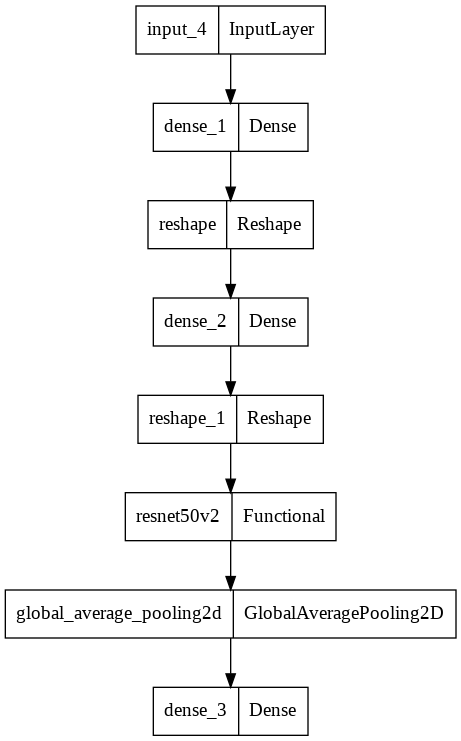

In [18]:
tf.keras.utils.plot_model(model, to_file="model.png")

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=5e-5)
checkpoint = ModelCheckpoint('backup/modelo_prueba{epoch:08d}.h5', 
                             save_freq = 'epoch', save_best_only=True, mode='min') 

In [17]:
history = model.fit(X_train, y_train, epochs = 500, batch_size = 8, 
                    callbacks=[learning_rate_reduction, early_stopping, checkpoint],
                    validation_data= (X_test, y_test))

Epoch 1/500
140/140 [==============================] - 30s 124ms/step - loss: 18900.5645 - mae: 18900.5645 - val_loss: 18230.0547 - val_mae: 18230.0547 - lr: 0.0100
Epoch 2/500
140/140 [==============================] - 16s 113ms/step - loss: 17262.4473 - mae: 17262.4473 - val_loss: 16335.5771 - val_mae: 16335.5771 - lr: 0.0100
Epoch 3/500
140/140 [==============================] - 30s 215ms/step - loss: 15371.9395 - mae: 15371.9395 - val_loss: 14826.4150 - val_mae: 14826.4150 - lr: 0.0100
Epoch 4/500
140/140 [==============================] - 29s 208ms/step - loss: 14156.5000 - mae: 14156.5000 - val_loss: 14125.7480 - val_mae: 14125.7480 - lr: 0.0100
Epoch 5/500
140/140 [==============================] - 26s 190ms/step - loss: 13425.2139 - mae: 13425.2139 - val_loss: 13194.3506 - val_mae: 13194.3506 - lr: 0.0100
Epoch 6/500
140/140 [==============================] - 28s 199ms/step - loss: 12895.1523 - mae: 12895.1523 - val_loss: 12919.0547 - val_mae: 12919.0547 - lr: 0.0100
Epoch 7/50

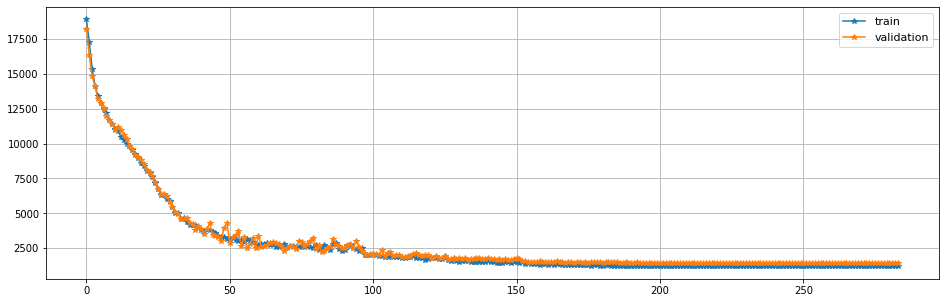

In [20]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [34]:
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_pred_redes = model.predict(X_new, verbose=1)

44/44 [==============================] - 1s 25ms/step


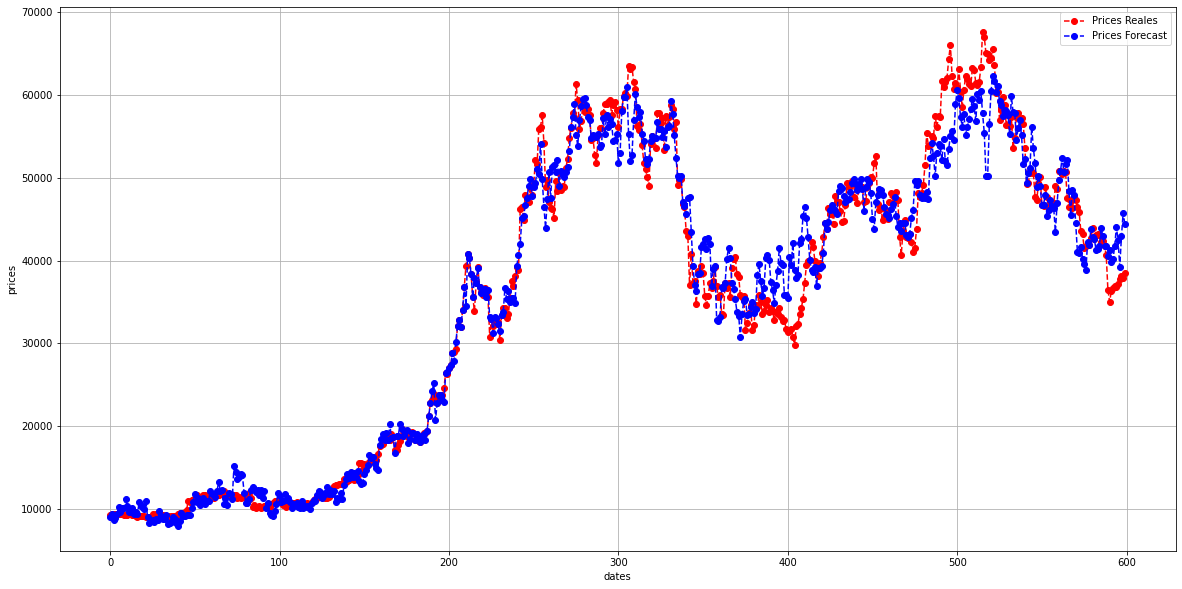

In [43]:
fig=plt.figure(figsize=(20, 10))
plt.plot(y[800:], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_redes[800:], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [ ]:
#y_test_original = y_test * (maximo - minimo) + minimo
#y_pred_redes_ok = y_pred_redes * (maximo - minimo) + minimo
#y_pred_baseline_ok = y_pred_baseline * (maximo - minimo) + minimo

y_test_original = y_test 
y_pred_redes_ok = y_pred_redes 
#y_pred_baseline_ok = y_pred_baseline 

In [ ]:
errores_redes = np.empty([len(y_test_original)])
#errores_baseline = np.empty([len(y_test_original)])
for i in range(0,len(y_test_original)):
    errores_redes[i] = np.linalg.norm(y_test_original[i] - y_pred_redes_ok[i], np.inf)
    #errores_baseline[i] = np.linalg.norm(y_test_original[i] - y_pred_baseline_ok[i], np.inf)

In [ ]:
print("Errores usando Redes")
print(pd.DataFrame(errores_redes).describe().transpose().round(2))
# print("Errores usando Baseline")
# print(pd.DataFrame(errores_baseline).describe().transpose().round(2))

Errores usando Redes
   count    mean      std    min      25%      50%      75%       max
0  200.0  7471.9  3310.08  91.95  5312.82  7324.65  8974.16  17013.85


In [ ]:
#s1 = errores_baseline[errores_baseline < np.percentile(errores_baseline, 95)]
s2 = errores_redes[errores_redes < np.percentile(errores_redes, 95)]

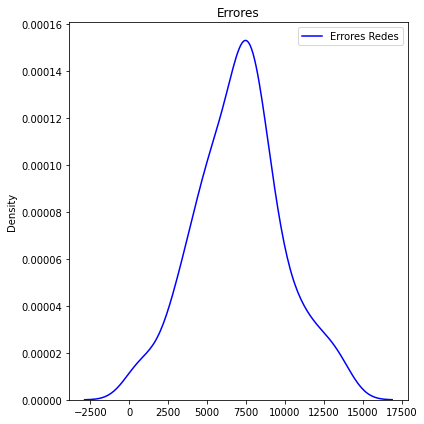

In [ ]:
plt.figure(figsize=(6,6))
#sns.kdeplot(s1, color = "red",  label = 'Errores Baseline')
sns.kdeplot(s2, color = "blue", label = 'Errores Redes')
plt.title('Errores')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# best_baseline = np.argmin(errores_baseline)
# worse_baseline = np.argmax(errores_baseline)
# print("Posicion mejor Baseline Model: " + str(best_baseline))
# print("Posicion peor Baseline Model: " + str(worse_baseline))

best_redes = np.argmin(errores_redes)
worse_redes = np.argmax(errores_redes)
print("Posicion mejor Redes Model: " + str(best_redes))
print("Posicion peor Redes Model: " + str(worse_redes))

Posicion mejor Redes Model: 5
Posicion peor Redes Model: 83


<Figure size 1440x432 with 0 Axes>

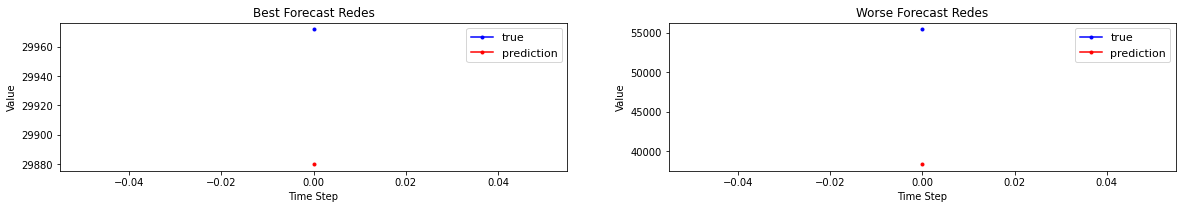

In [ ]:
plt.figure(figsize=(20, 6))
#plt.subplot(111)
# plt.title("Best Forecast Baseline")
# plt.plot(y_test[best_baseline], color = "blue", marker='.', label="true")
# plt.plot(y_pred_baseline[best_baseline], color = 'red', marker = ".", label="prediction")
# plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

# plt.subplot(222)
# plt.title("Worse Forecast Baseline")
# plt.plot(y_test[worse_baseline], color = "blue", marker='.', label="true")
# plt.plot(y_pred_baseline[worse_baseline], color = 'red', marker = ".", label="prediction")
# plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Redes")
plt.plot(y_test[best_redes],  color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[best_redes][0], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Redes")
plt.plot(y_test[worse_redes], color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[worse_redes][0], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();